In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# to scale the data using zscore
from sklearn.preprocessing import StandardScaler

#import clustering algorithms
from sklearn.cluster import KMeans

# Agglomerative clustering 
from sklearn.cluster import AgglomerativeClustering

#silhoutte score
from sklearn.metrics import silhouette_score


import warnings
warnings.filterwarnings('ignore')


# Loading the data


In [3]:
data = pd.read_csv('Country-data.csv',skipinitialspace=True)
data.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


### OBSERVATIONS:
- there are 167 observations and 10 columns.
- all columns have 167 non-null values i.e. no missing values are present.
- all columns except the country name afre numerical.


# checking for duplicate entries


In [5]:
 data.duplicated().sum()


0


there are no duplicated rows in the data.

# EXPLORATORY DATA ANALYSIS


SUMMARY STATISTICS



In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


# Observations:
- The child mortality rate has a high range from 2.6 to 208 deaths per 1000 live births. The average child mortality rate is approx 38 deaths per 1000 live births.
- Similarly, the exports and imports have a high range of values. The maximum values for exports and imports are 200% and 174% of GDP respectively. This can happen if a country's export or import industry exceeds its domestic economy.
- The total spend on health is very less in comparison to exports and imports for the majority of countries. The average spending on health is approx 6.8% of GDP.
- The average life expectancy is approx 70 years but the minimum value is just 32 years.
- Other variables like gdpp, inflation, and income also show a high variability which can be expected as they can be very different for different countries.
- Overall, % expenditure on health and average life expectancy seem to have a lesser standard deviation, which reflects less variability across countries. All other variables seem to have a very high spread across countries. These are the variables that might help us identify the clusters if they exist.

# Let's check the distribution and outliers for each column in the data


child_mort
Skew : 1.45


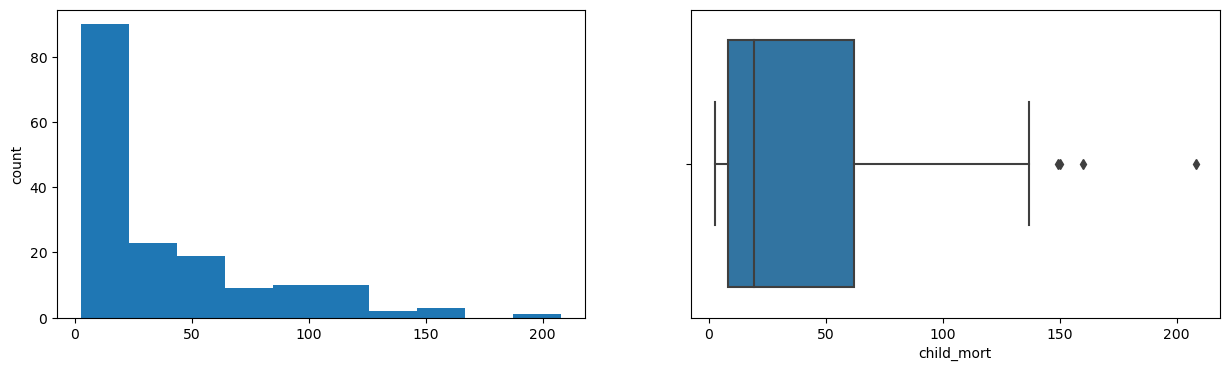

exports
Skew : 2.45


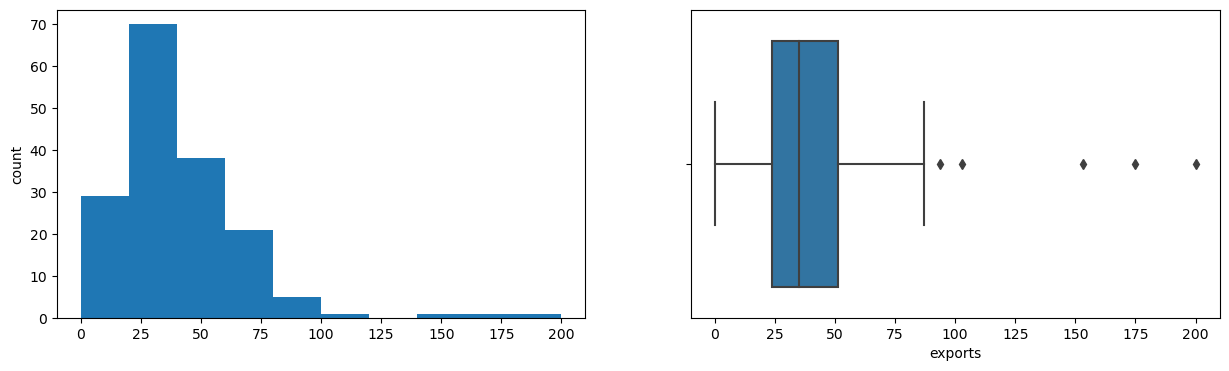

health
Skew : 0.71


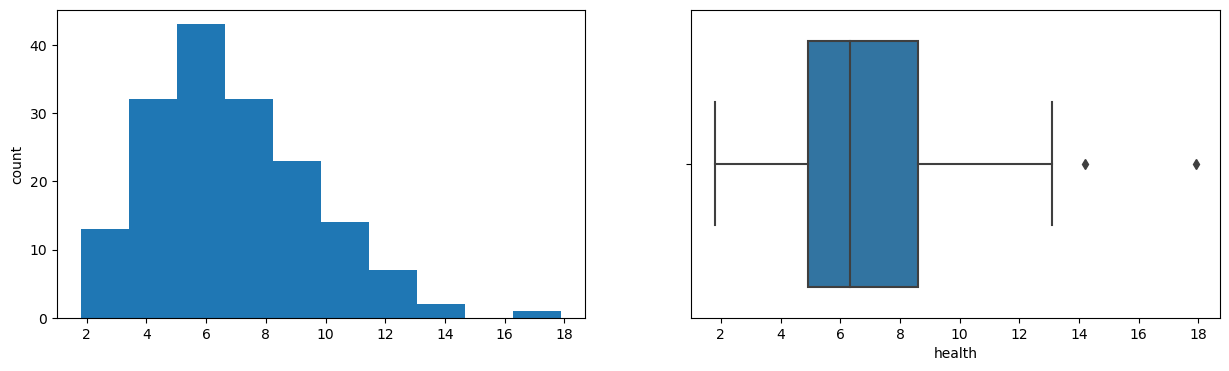

imports
Skew : 1.91


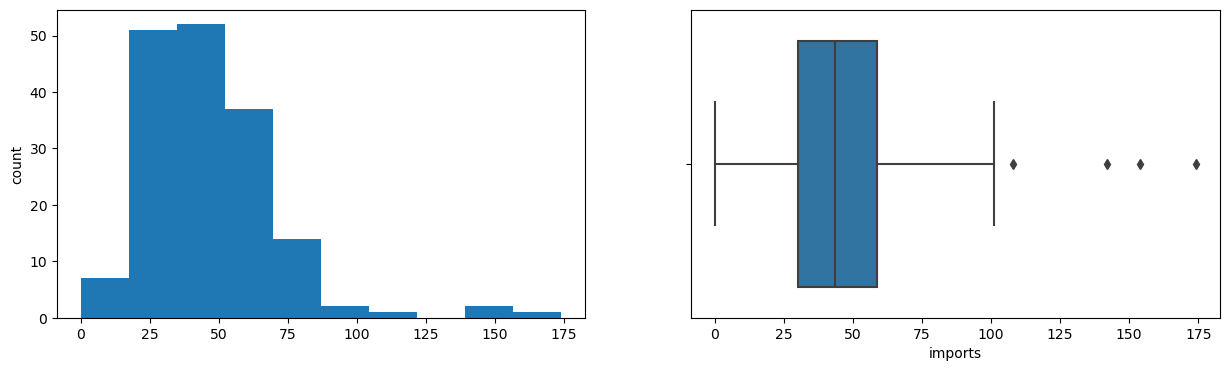

income
Skew : 2.23


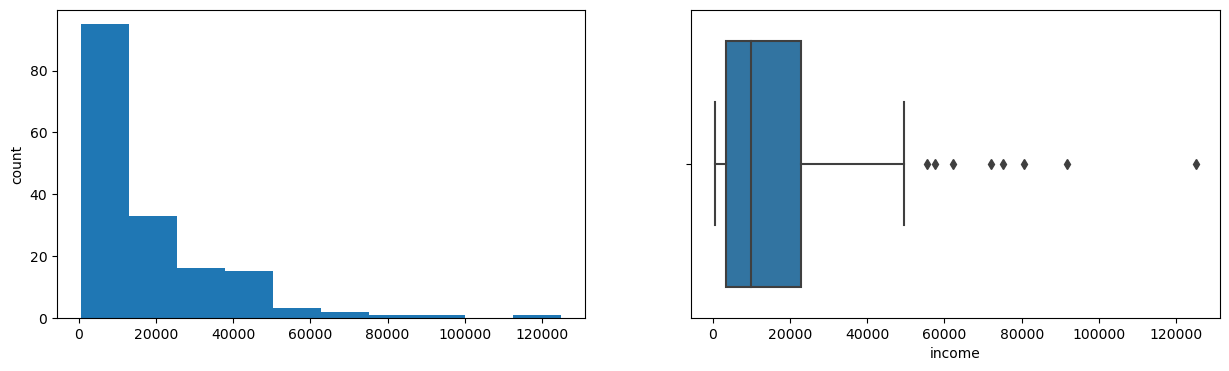

inflation
Skew : 5.15


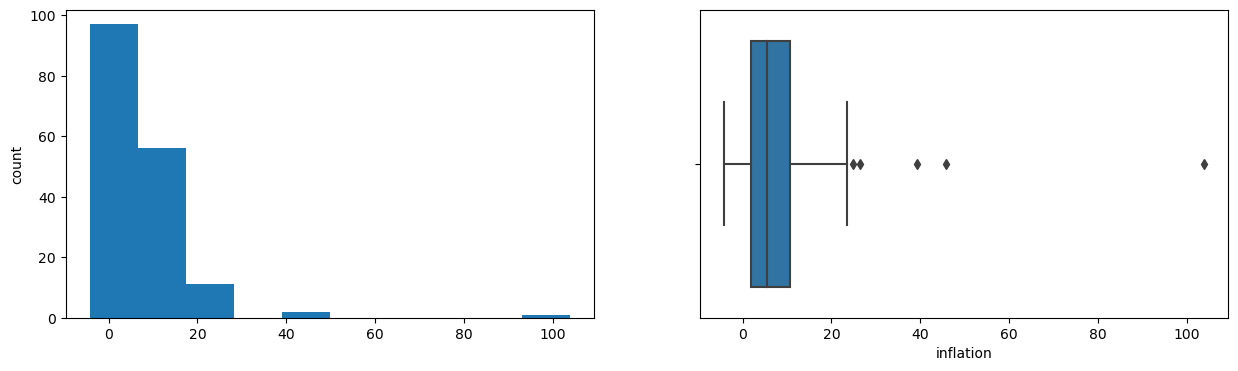

life_expec
Skew : -0.97


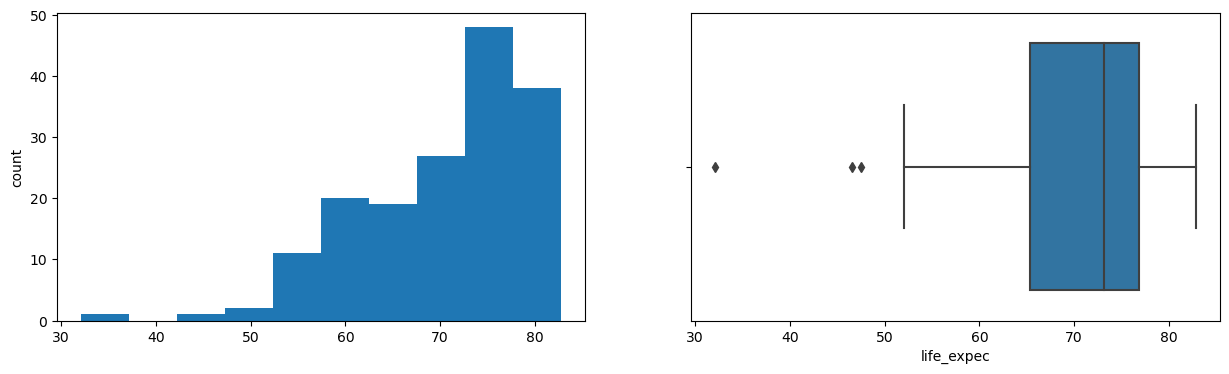

total_fer
Skew : 0.97


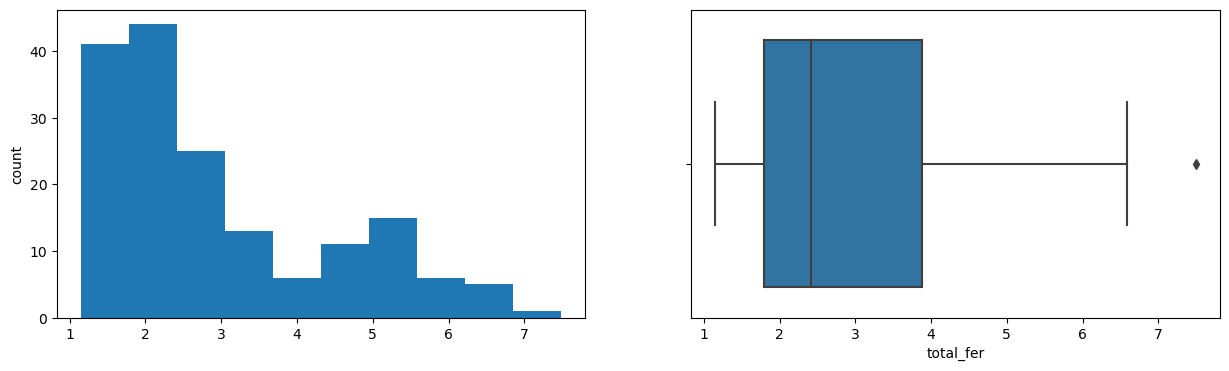

gdpp
Skew : 2.22


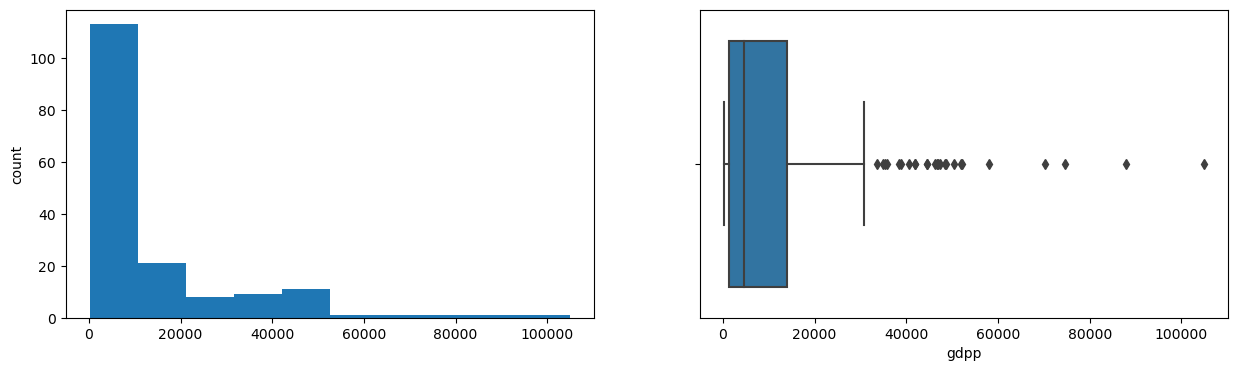

In [7]:
for col in data.columns[1:]:
    print(col)
    
    print('Skew :',round(data[col].skew(),2))
    plt.figure(figsize = (15,4))
    plt.subplot(1,2,1)
    data[col].hist(bins = 10,grid = False)
    plt.ylabel('count')
    plt.subplot(1,2,2)
    sns.boxplot(x = data[col])
    plt.show()

# let's check the correlation among the variables

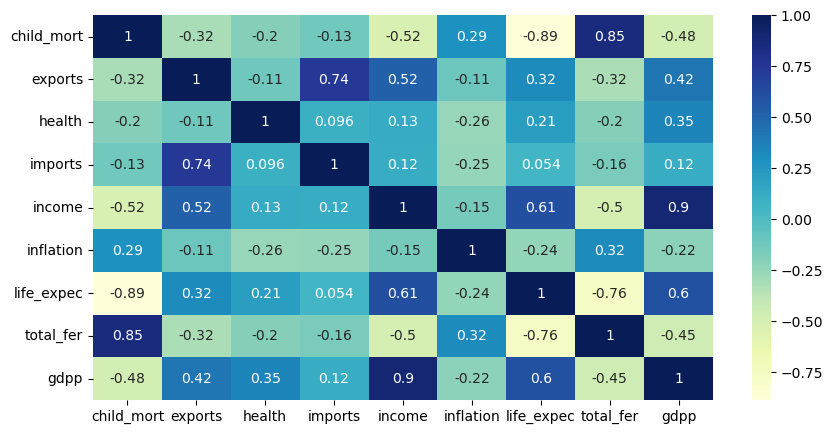

In [8]:
plt.figure(figsize = (10,5))
sns.heatmap(data.corr(),annot = True,cmap = 'YlGnBu')
plt.show()

# Observations

- there is a strong positive correlation between income and gdp.This makes sense.
- a strong positive correlation is also seen between child mortality and total fertility rate.
- a strong negative correlation is there between child mortality rate and life expectancy. this is understandable.
- life expectancy is positively correlated with gdp . this shows that people live longer in richer countries.

# scaling the data

- Clustering algorithms are distance-based algorithms, and all distance-based algorithms are affected by the scale of the variables. Therefore, we will scale the data before applying clustering.

- We will drop the variables 'country' variable because it is unique for each country and would not add value to clustering.

- we will also drop the gdp variable now,because we want to see if we can identify clusters of countries without relying on gdp and see later if these clusters correspond to an avg gdp value for the countries in each cluster.

In [9]:
data_new = data.drop(columns = ['country','gdpp'])

In [10]:
# scaling the data and storing the output as a new dataframe

scaler = StandardScaler()

data_scaled = pd.DataFrame(scaler.fit_transform(data_new),columns = data_new.columns)

In [11]:
data_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer
0,1.291532,-1.138280,0.279088,-0.082455,-0.808245,0.157336,-1.619092,1.902882
1,-0.538949,-0.479658,-0.097016,0.070837,-0.375369,-0.312347,0.647866,-0.859973
2,-0.272833,-0.099122,-0.966073,-0.641762,-0.220844,0.789274,0.670423,-0.038404
3,2.007808,0.775381,-1.448071,-0.165315,-0.585043,1.387054,-1.179234,2.128151
4,-0.695634,0.160668,-0.286894,0.497568,0.101732,-0.601749,0.704258,-0.541946


In [12]:
data_scaled.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer
count,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02,1.670000e+02
mean,-3.722904e-17,2.127373e-16,5.504579e-16,2.765585e-16,-7.977650e-17,-1.063687e-17,3.696311e-16,3.044803e-16
std,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00,1.003008e+00
min,-8.871383e-01,-1.500192e+00,-1.827827e+00,-1.939940e+00,-8.603259e-01,-1.137852e+00,-4.337186e+00,-1.191250e+00
25%,-7.466190e-01,-6.333367e-01,-6.922106e-01,-6.914785e-01,-7.174558e-01,-5.666409e-01,-5.927576e-01,-7.639023e-01
50%,-4.717981e-01,-2.235279e-01,-1.810007e-01,-1.487432e-01,-3.738080e-01,-2.269504e-01,2.869576e-01,-3.564309e-01
75%,5.926666e-01,3.747198e-01,6.515412e-01,4.913530e-01,2.942370e-01,2.816364e-01,7.042584e-01,6.175252e-01
max,4.221297e+00,5.813835e+00,4.047436e+00,5.266181e+00,5.611542e+00,9.129718e+00,1.380962e+00,3.009349e+00


In [13]:
# creating copy of scaled data to ensure that if the data is needed at later stage , I have stored labels from each algorithm.

data_scaled_copy = data_scaled.copy(deep = True)

# Hierarchical Clustering

- let's try to create clusters using agglomerative hierarchical clustering

-  here we decide the number of clusters using a concept called Dendrogram which is tree-like diagram that records the sequences of merges or splits

In [14]:
from scipy.cluster.hierarchy import dendrogram,linkage

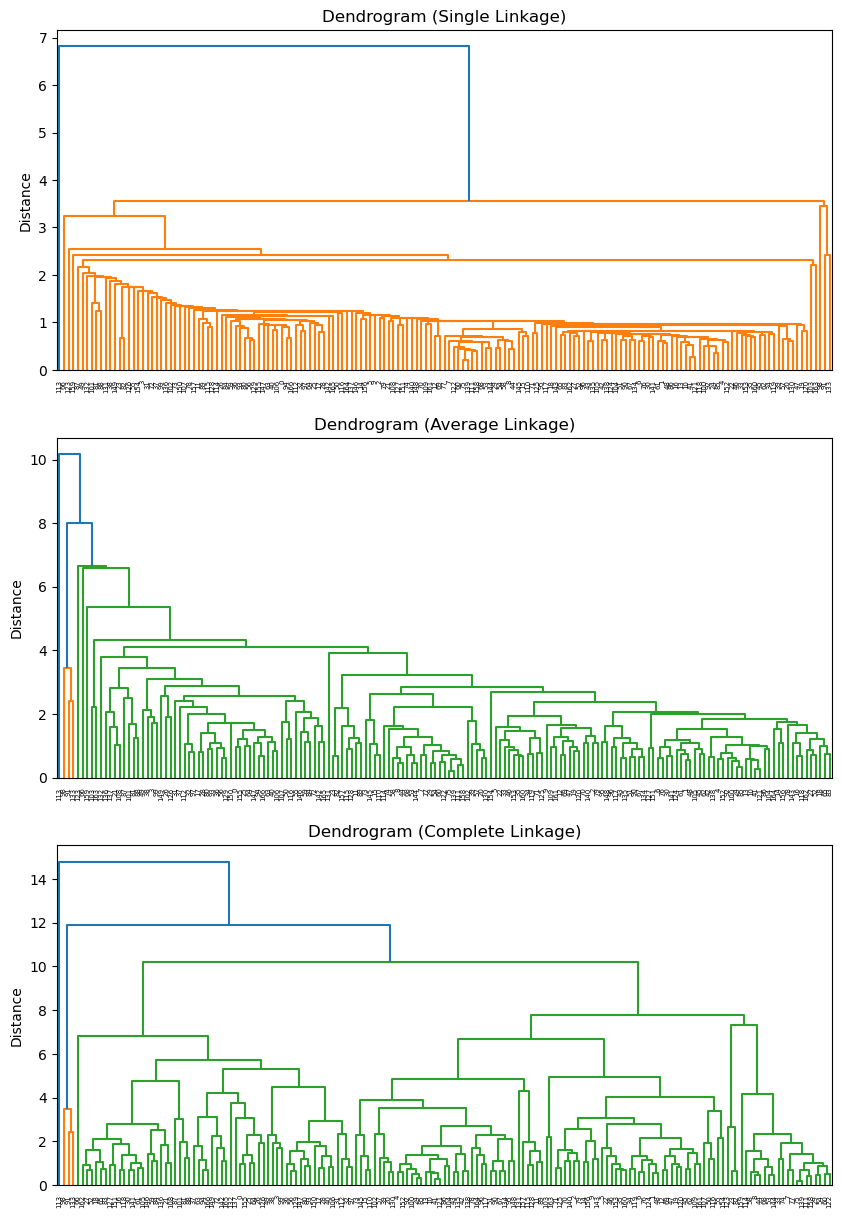

In [15]:
# list of all linkage methods to check

methods = ['single','average','complete']

# create a subplot image
fig,axs = plt.subplots(len(methods),1,figsize = (10,15))

# enumerate through the list of all methods above, get linkage aND DRAW DENDROGRAM.

for i ,method in enumerate(methods):
    Z = linkage(data_scaled, metric = 'euclidean',method = method)
    
    dendrogram (Z, ax =axs[i])
    axs[i].set_title(f'Dendrogram ({method.capitalize()} Linkage)')
    axs[i].set_ylabel('Distance')

- we can see that if we create a horizontal line at the threshold distance  9 , it  cuts 4 vrtical lines.
- let's fit the algorithm using 4 as the number of clusters.

In [16]:
#clustering with 4 clusters 
hierarchical = AgglomerativeClustering(n_clusters = 4,affinity= 'euclidean',linkage = 'complete')

hierarchical.fit(data_scaled)

AgglomerativeClustering(affinity='euclidean', linkage='complete', n_clusters=4)

In [17]:
data_scaled_copy['HCLabels'] = hierarchical.labels_

data['HCLabels'] = hierarchical.labels_



In [18]:
data.HCLabels.value_counts()

0    103
1     60
2      3
3      1
Name: HCLabels, dtype: int64

- the count of observations in the resulting 4 clusters is unevenly distributed.
- we have 2 clusters with only 3 countries and 1 country respectively 

In [19]:
#checking 3 countries in cluster 2

data[data.HCLabels == 3]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,HCLabels
113,Nigeria,130.0,25.3,5.07,17.4,5150,104.0,60.5,5.84,2330,3


- similar to kmeans, we got a seperate cluster for 3 small countries with the highest values for imports and exports:

In [20]:
data[data.HCLabels ==2]

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,HCLabels
91,Luxembourg,2.8,175.0,7.77,142.0,91700,3.620,81.3,1.63,105000,2
98,Malta,6.8,153.0,8.65,154.0,28300,3.830,80.3,1.36,21100,2
133,Singapore,2.8,200.0,3.96,174.0,72100,-0.046,82.7,1.15,46600,2


- cluster 3  consists of just 1 country Nigeria
- Nigeria has an inflation rate of 104 which is the highest inflation rate in the dataset. this might have made its distance with the other clusters significantly  higher not allowing it to merge with other clusters.

In [23]:
# calculating mean and median of the original data for each label

original_features = ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']

mean = data.groupby('HCLabels').mean()
median = data.groupby('HCLabels').median()

df_hierarchical = pd.concat([mean,median],axis = 0)

df_hierarchical.index = ['group_0 mean','group_1 mean','group_2 mean','group_3 mean','group_0 median','group_1 median','group_2 median','group_3 median']

df_hierarchical[original_features].T

,group_0 mean,group_1 mean,group_2 mean,group_3 mean,group_0 median,group_1 median,group_2 median,group_3 median
child_mort,16.678641,75.513333,4.133333,130.00,10.80,73.300,2.80,130.00
exports,42.532806,32.183667,176.000000,25.30,38.70,28.900,175.00,25.30
health,7.013883,6.505667,6.793333,5.07,6.91,5.685,7.77,5.07
imports,42.438504,49.535000,156.666667,17.40,38.40,47.650,154.00,17.40
income,23425.533981,4218.050000,64033.333333,5150.00,17800.00,2500.000,72100.00,5150.00
inflation,6.723262,8.261100,2.468000,104.00,4.49,5.860,3.62,104.00
life_expec,75.471845,61.740000,81.433333,60.50,76.10,61.300,81.30,60.50
total_fer,2.074660,4.477333,1.380000,5.84,1.93,4.710,1.36,5.84
gdpp,18053.689320,2174.233333,57566.666667,2330.00,10700.00,1185.000,46600.00,2330.00


# OBSERVATIONS

- It looks like cluster 2 has only 3 countries with high income and high gdpp. cluster1 has low income and low gdpp countries and the rest of the countries are in cluster 0 except for 1 country which is in cluster 3.

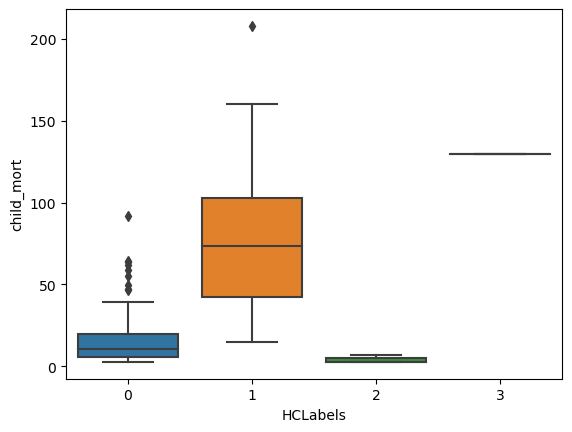

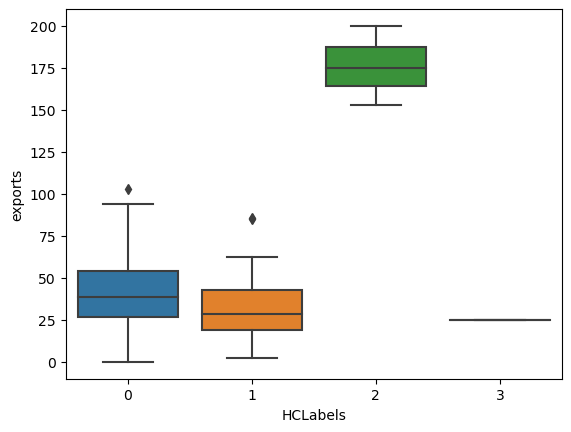

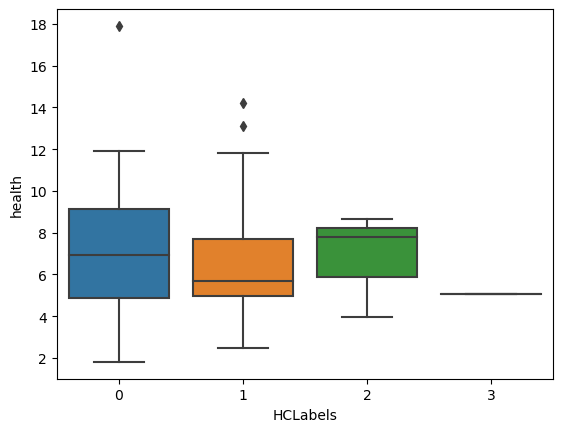

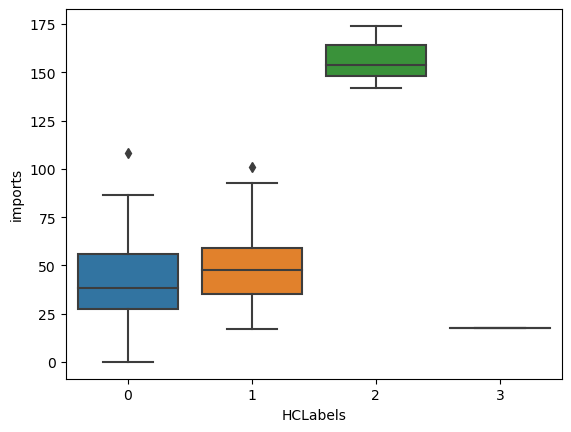

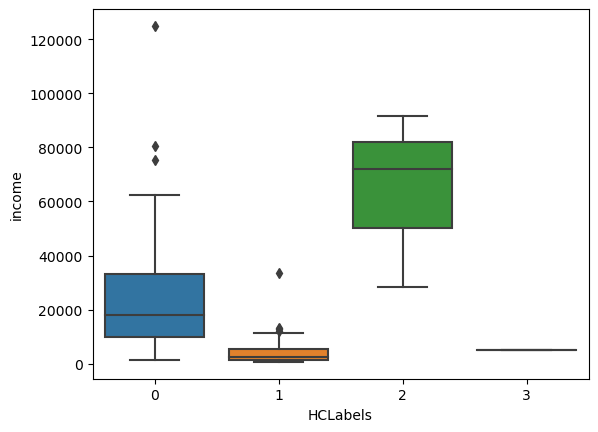

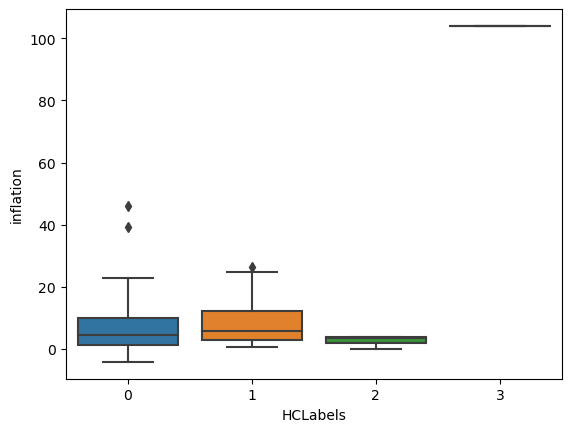

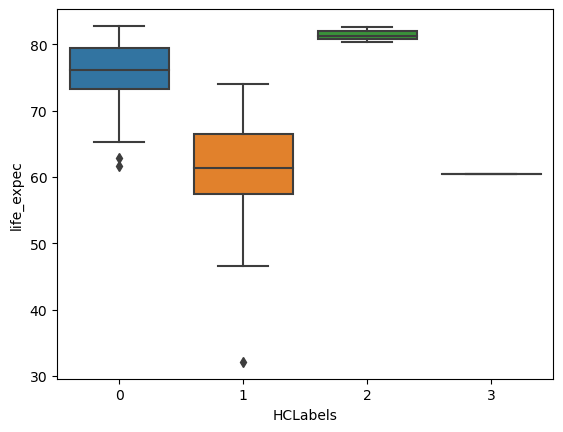

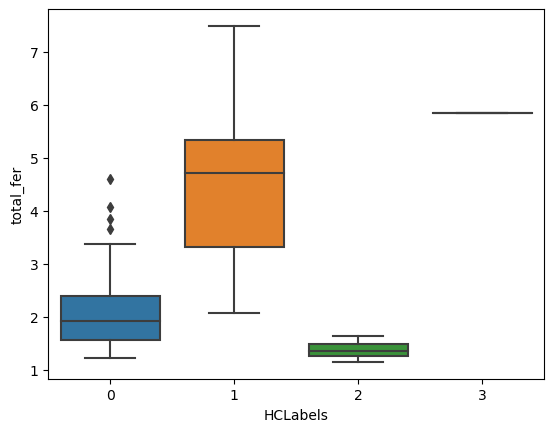

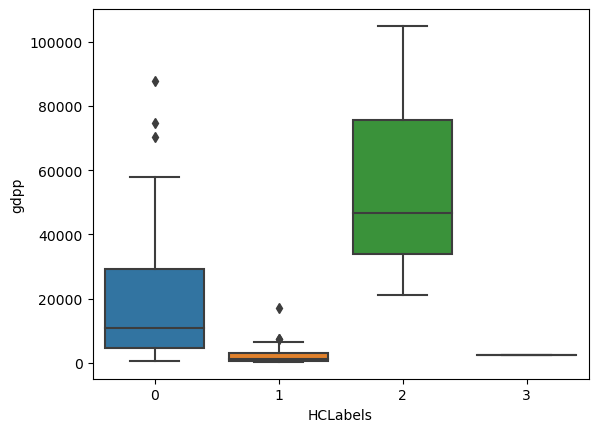

In [24]:
cols_visualize =  ['child_mort','exports','health','imports','income','inflation','life_expec','total_fer','gdpp']

for col in cols_visualize:
    sns.boxplot(x = 'HCLabels',y = col, data = data)
    plt.show()